<a href="https://colab.research.google.com/github/madhav48/FinSearch2k24/blob/main/Inverted_Pendulum_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries...

In [ ]:
!pip install gym
!pip install tensorflow

# Import libraries...


In [2]:
import gym

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque

import random
import os
import shutil

import imageio
from PIL import Image

from IPython.display import Image as IPyImage
from IPython.display import display

# Create Environment..

- Setup the environment using GYM and check out the properties of action and observation space.

In [3]:
# Specify the `render_mode` parameter to show the capture the pendulum UI.
env = gym.make("Pendulum-v1", render_mode="rgb_array", new_step_api=True)

# Access the observation space properties
print("---------------- OBSERVATION SPACE ----------------------------")
observation_space = env.observation_space
print("Observation Space:", observation_space)

# Sample an observation...
observation = env.reset()
print("Initial Observation:", observation)

# Access the shape and bounds of the observation space..
print("Shape of Observation Space:", observation_space.shape[0])
print("Low (Minimum) Values:", observation_space.low)
print("High (Maximum) Values:", observation_space.high)

print("\n---------------- ACTION SPACE ----------------------------")

# Access the number of actions..
num_actions = env.action_space.shape[0]
print("Size of Action Space: " + f"{num_actions}")

# Access the upper and minimum values of action..
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action: " + f"{upper_bound}")
print("Min Value of Action: " + f"{lower_bound}")

---------------- OBSERVATION SPACE ----------------------------
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Initial Observation: [-0.91435903  0.4049044   0.25803787]
Shape of Observation Space: 3
Low (Minimum) Values: [-1. -1. -8.]
High (Maximum) Values: [1. 1. 8.]

---------------- ACTION SPACE ----------------------------
Size of Action Space: 1
Max Value of Action: 2.0
Min Value of Action: -2.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Deep Q-Network (DQN) Model

- This class contains the neural network which store the weight for primary network and target network.

In [4]:
class DQN(models.Model):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu', input_dim=state_dim)
        self.dense2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(action_dim, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Define Replay Buffer

- This is the memory which will be used to store experiences.
- These expereinces are helpful later on as if model model wants to learn from its older experience.

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Define Agent with Training Function

<br>

- DQNAgent class is the most important class, which will handle all the tasks.
- Act : This function is used to decide what should be the next step of pendulum using epsilion - greedy approach.
- Epsilion fraction  steps will be randomized which means exploration, rest is exploitation.
- Train:   This is function is used to train the model by taking refrence of target network and using replay (which trains it using previous experiences)
- Test: This function enables the model to show its output and take steps using its learning, and stores the corresponding images to the output folder..


In [6]:
class DQNAgent:
    def __init__(self, env):

        # Define environment and get the parameters for action and observation space..
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]

        # Initialize the DQN - Primary and Target Network and copy the wieghts for first time..
        self.model = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.target_model.set_weights(self.model.get_weights())

        # Compile the model...
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

        # Specify parameters for exploration-exploitation and how should that process go throught the training..
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.001

        # Specify batch size for sampling of memory and initlize the memory with a good enough size..
        self.batch_size = 64
        self.buffer = ReplayBuffer(capacity=10000)

    def act(self, state):

        """ Function to take calls to act, according to epsilion-greedy approach and finally return the action to execute.. """

        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        q_values = self.model.predict(np.expand_dims(state, axis=0))

        # Clip action values to be within the action space..
        return np.clip(q_values[0], -2, 2)

    def train(self, num_episodes):

        """ Function to train the model.. """

        for episode in range(num_episodes):

            # Reset the environment and get the initial state..
            state = self.env.reset()
            state = state.astype(np.float32)
            total_reward = 0

            # Loop until the episode ends..
            done = False
            truncated = False
            while not (done or truncated):

                # Take action using epsilon-greedy approach..
                action = self.act(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = next_state.astype(np.float32)

                # Store the experience in the memory..
                self.buffer.add((state, action, reward, next_state, done))

                # Accumulate total reward and move to the next state..
                total_reward += reward
                state = next_state

                # Perform experience replay..
                self.replay()

            # Update exploration rate epsilon and print results for each episode..
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            print(f"Episode: {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon}")



    def replay(self):

        """ Function to perform experience replay.. """

        # Check if the buffer has enough samples to train the model..
        if len(self.buffer) < self.batch_size:
            return

        # Sample a batch of experiences from the buffer and predict Q-Values..
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        q_values_next = self.target_model.predict(next_states)

         # Calculate target Q-values using Bellman equation and Predict current Q-values for the sampled states using the main model..
        targets = rewards + (1 - dones) * self.gamma * np.max(q_values_next, axis=1)
        target_vec = self.model.predict(states)

        # Instead of indexing with actions, directly update target_vec..
        for i in range(self.batch_size):
            target_vec[i] = targets[i]

        # Train the model on the batch of states and updated target Q-values..
        self.model.train_on_batch(states, target_vec)

        # Update the target model weights perodically...
        if len(self.buffer) % 10 == 0:
            self.target_model.set_weights(self.model.get_weights())


    def test(self, num_episodes=5, save_path='pendulum_frames'):

        """ Function to test the model.."""

        # Check if the directory exists to save images for UI.
        if not os.path.exists(save_path):
            # Create the directory if it doesn't exist
            print(f"Creating directory: {save_path}")
            os.makedirs(save_path)

        else:
            # If the directory is not empty..
            if os.listdir(save_path):

                # Clear the contents of the directory
                for filename in os.listdir(save_path):
                    file_path = os.path.join(save_path, filename)

                    try:
                        if os.path.isfile(file_path):
                            os.unlink(file_path)

                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)

                    except Exception as e:
                        print(f"Failed to delete {file_path}. Reason: {e}")

                print(f"Directory '{save_path}' cleared.")

            else:
                print(f"Directory '{save_path}' is already empty.")

        # Test the model..
        for episode in range(num_episodes):

            # Reset the environment and get the initial state..
            state = self.env.reset()
            state = state.astype(np.float32)
            total_reward = 0

            # Loop until the episode ends..
            done = False
            truncated = False
            t = 0
            while not (done or truncated):

                # Create a path to save image for current situtaion..
                frame_path = os.path.join(save_path, f"episode_{episode}_frame_{t}.png")
                # Render image from environment and save it to the created path..
                img = self.env.render(mode= "rgb_array")
                if img != []:
                    img = np.squeeze(np.uint8(img), axis=0)
                    img = Image.fromarray(img)
                    img.save(frame_path)

                # Take action using epsilon-greedy approach..
                action = self.act(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = next_state.astype(np.float32)

                # Accumulate total reward and move to the next state..
                total_reward += reward
                state = next_state
                t += 1
            print(f"Episode: {episode + 1}/{num_episodes}, Total Reward: {total_reward}")


# Initialize the Training Agent

In [7]:
# Initialize agent..
agent = DQNAgent(env)

# Simulation Functions - Compile to GIF

In [8]:
def create_gif(frame_folder, output_path):

    # Create a GIF from the frames in the folder...

    frames = []
    for frame_name in sorted(os.listdir(frame_folder)):
        frame_path = os.path.join(frame_folder, frame_name)
        frames.append(imageio.imread(frame_path))
    imageio.mimsave(output_path, frames, fps=30)


def test_agent(agent):

    # Test the model..
    agent.test(num_episodes=5, save_path='pendulum_frames')

    # Create the GIF
    create_gif('pendulum_frames', 'pendulum_training.gif')

    # Display the GIF
    display(IPyImage(filename='pendulum_training.gif'))


# Before Training

- Test the agent on the initial model having random weights..
- Create and dipslay a GIF simulating the working of model..

Creating directory: pendulum_frames


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/5, Total Reward: -1406.2291627104025
Episode: 2/5, Total Reward: -1374.3779497738208
Episode: 3/5, Total Reward: -1407.986688566578
Episode: 4/5, Total Reward: -1590.8617563550995
Episode: 5/5, Total Reward: -1284.294477058293


<ipython-input-8-af3c50a08541>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))
/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


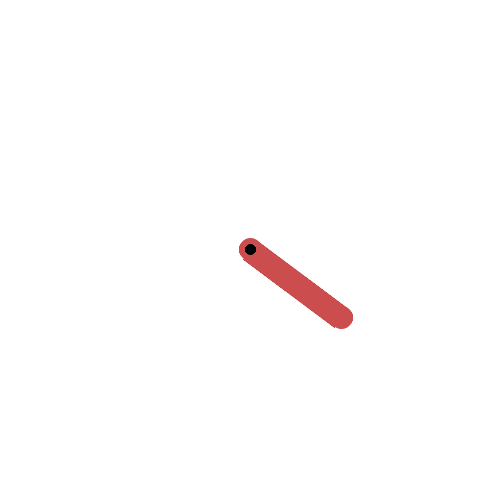

In [9]:
test_agent(agent)

#Train The Model

In [ ]:
# Train agent..
agent.train(num_episodes=300)

# After Training

- Test the agent on the  model having new weights after training..
- Create and dipslay a GIF simulating the working of model..

Directory 'pendulum_frames' cleared.
1/1 [==============================] - 0s 16ms/step
Episode: 1/5, Total Reward: -1595.3519363864966
1/1 [==============================] - 0s 16ms/step
Episode: 2/5, Total Reward: -1064.4067183046598
1/1 [==============================] - 0s 15ms/step
Episode: 3/5, Total Reward: -1596.4448187189146
1/1 [==============================] - 0s 15ms/step
Episode: 4/5, Total Reward: -1701.2913559761062
1/1 [==============================] - 0s 16ms/step
Episode: 5/5, Total Reward: -1134.5402497326118


<ipython-input-8-af3c50a08541>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


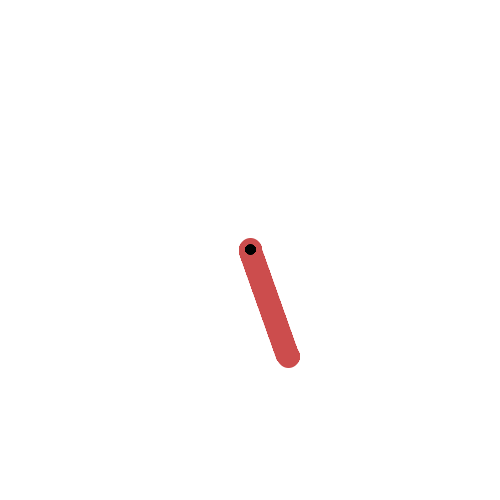

In [11]:
test_agent(agent)